# AI-Powered Brain Tumor Detection: Enhancing Diagnostic Accuracy through Deep Learning and MRI Analysis

This project leverages Convolutional Neural Networks (CNNs) to classify brain MRI images into four categories—glioma, meningioma, pituitary tumor, and no tumor—using a hybrid dataset. The goal is to support early diagnosis and clinical decision-making by providing a reliable, multi-task classification system for brain tumors

## Import Dependences

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import shutil
import os
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.utils import to_categorical

2025-08-25 14:38:04.699536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756132685.021721      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756132685.114533      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Check Versions

In [3]:
tf.__version__,cv2.__version__

('2.18.0', '4.11.0')

In [4]:
!python --version

Python 3.11.11


## Check Devices 

In [5]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


## Load Dataset

In [6]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

## Data Visualization

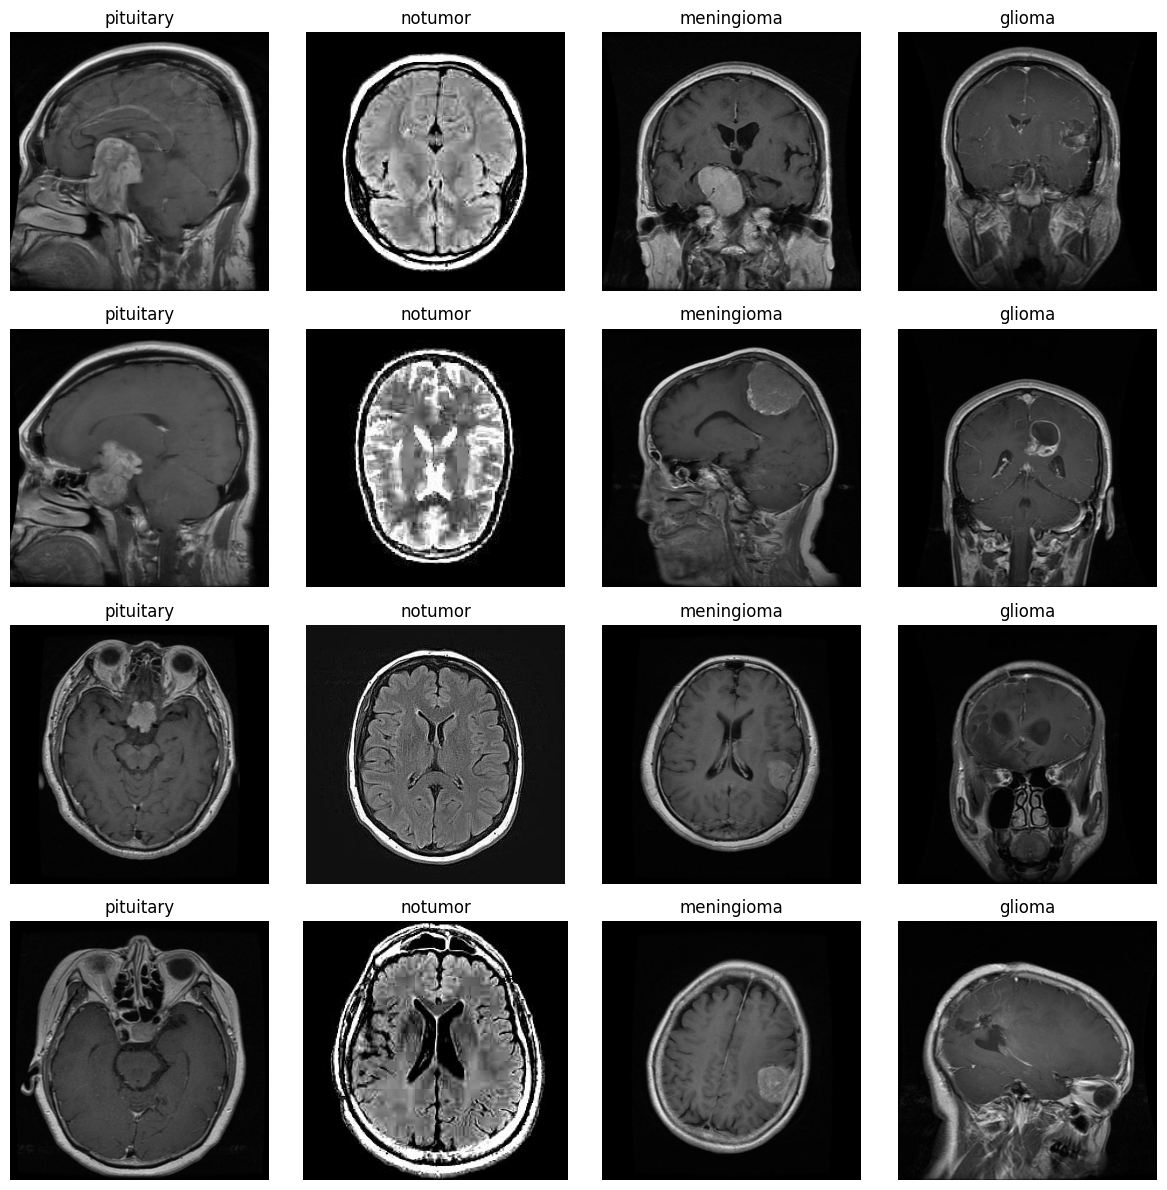

In [7]:
main_folder = r'/kaggle/input/brain-tumor-mri-dataset/Training'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

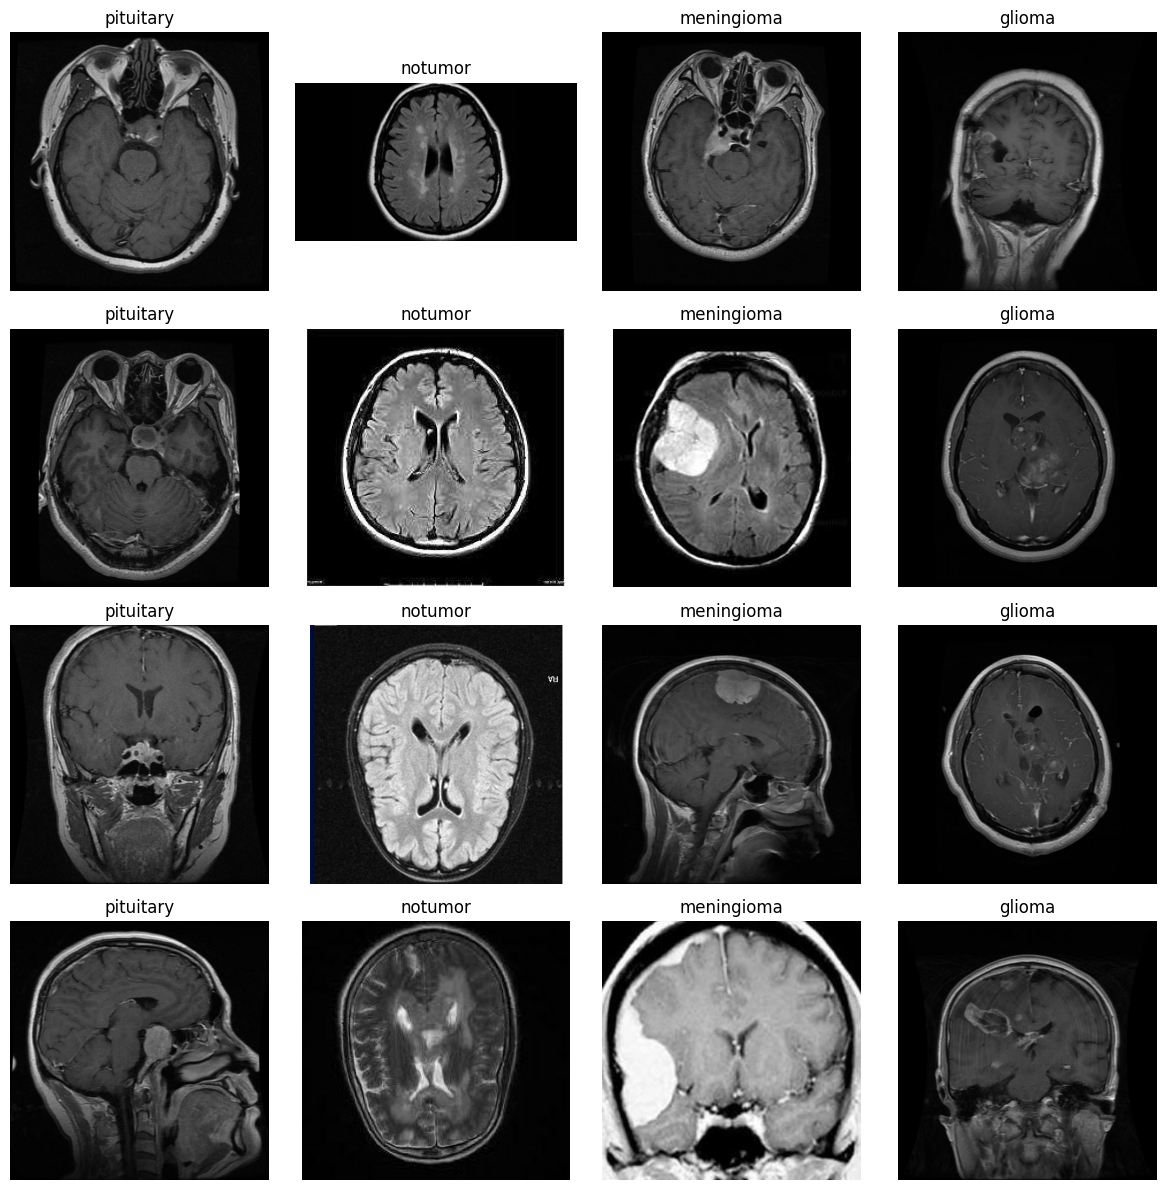

In [8]:

main_folder = r'/kaggle/input/brain-tumor-mri-dataset/Testing'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

## Data Preprocessing

In [9]:
IMAGE_SIZE = 224

BATCH_SIZE = 32

In [10]:
def cnn_preprocess(x):
    return x/255.0

In [11]:
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_train_generator = cnn_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [12]:
cnn_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [13]:
cnn_test_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_test_generator = cnn_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [14]:
cnn_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

## CNN Model Building

In [15]:
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
])

I0000 00:00:1756132708.486968      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756132708.487676      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
# cnn_model = keras.Sequential([
#     keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

#     # First conv block
#     keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.25),

#     # Second conv block
#     keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.25),

#     # Third conv block
#     keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.25),

#     # Fourth conv block (optional - for deeper feature extraction)
#     keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.25),

#     # Dense layers
#     keras.layers.GlobalAveragePooling2D(),  # Alternative to Flatten + reduces parameters
#     keras.layers.Dense(units=512, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(units=256, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),

#     # Output layer
#     keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
# ])

In [17]:
# cnn_model = keras.Sequential([
#     keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    
#     keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),  
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.25),  
    
#     keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),  
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.25),  
    
#     keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),  
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.3),  
    
#     keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.Dropout(0.3),
    
#     keras.layers.Flatten(),
    
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(units=256, activation='relu'),
#     keras.layers.Dropout(0.5),  
    
#     keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dropout(0.4), 
    
#     keras.layers.Dense(units=64, activation='relu'),
    
#     keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
# ])

In [18]:
# cnn_model = keras.Sequential([
#     keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    
#     keras.layers.Conv2D(filters=32, kernel_size=(4, 4), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(3, 3)),
    
#     keras.layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(3, 3)),
    
#     keras.layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(3, 3)),
    
#     keras.layers.Flatten(),
    
#     keras.layers.Dense(units=512, activation='relu'),
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
# ])

In [19]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,200,964 (42.73 MB)

 Trainable params: 11,200,964 (42.73 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [21]:
cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),
                                   keras.metrics.Recall(name='recall'),
                                   keras.metrics.F1Score(name='f1_score')
])

In [22]:
cnn_history = cnn_model.fit(
        cnn_train_generator,
        epochs = 20,
        validation_data = cnn_test_generator,
        callbacks = callbacks
        )

Epoch 1/20


I0000 00:00:1756132715.509263      82 service.cc:148] XLA service 0x7a78c4002810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756132715.510832      82 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756132715.510854      82 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756132716.000906      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/179 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.2344 - f1_score: 0.1939 - loss: 1.3939 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1756132722.755391      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5358 - f1_score: 0.5007 - loss: 0.9997 - precision: 0.7676 - recall: 0.3122
Epoch 1: val_loss improved from inf to 0.56547, saving model to CNN_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 270ms/step - accuracy: 0.5366 - f1_score: 0.5016 - loss: 0.9985 - precision: 0.7678 - recall: 0.3133 - val_accuracy: 0.7780 - val_f1_score: 0.7612 - val_loss: 0.5655 - val_precision: 0.8080 - val_recall: 0.7124 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8328 - f1_score: 0.8233 - loss: 0.4551 - precision: 0.8560 - recall: 0.7998
Epoch 2: val_loss improved from 0.56547 to 0.45893, saving model to CNN_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.8328 - f1_score: 0.8233 - loss: 0.4550 - precision: 0.8560 - recall: 0.7999 - val_accuracy: 0.8276 - val_f1_score: 0.8175 - val_loss: 0.4589 - val_precision: 0.8427 - val_recall: 0.8047 - learning_rate: 1.0000e-04
Epoch 

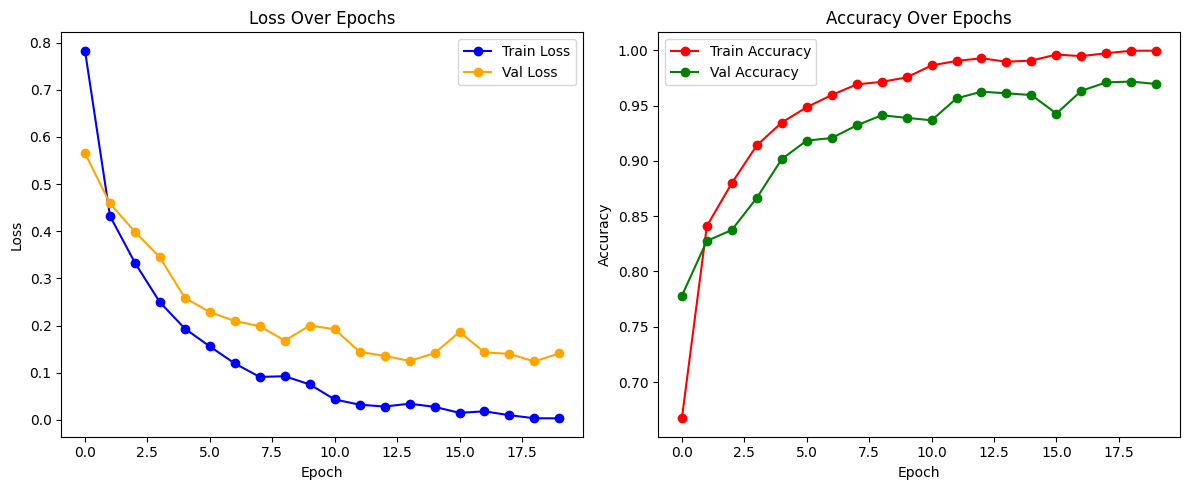

In [23]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Testing On New Data

In [24]:
def merge_brain_tumor_dataset(base_path, output_path):
    
    # Define the class names (subfolder names)
    classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    # Create output directory structure
    os.makedirs(output_path, exist_ok=True)
    
    for class_name in classes:
        class_output_dir = os.path.join(output_path, class_name)
        os.makedirs(class_output_dir, exist_ok=True)
        print(f"Created directory: {class_output_dir}")
    
    # Copy files from Training and Testing folders
    for folder_type in ['Training', 'Testing']:
        folder_path = os.path.join(base_path, folder_type)
        
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist!")
            continue
            
        print(f"\nProcessing {folder_type} folder...")
        
        for class_name in classes:
            source_dir = os.path.join(folder_path, class_name)
            target_dir = os.path.join(output_path, class_name)
            
            if not os.path.exists(source_dir):
                print(f"Warning: {source_dir} does not exist!")
                continue
            
            # Get all image files from source directory
            image_files = [f for f in os.listdir(source_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            print(f"  {class_name}: Found {len(image_files)} images")
            
            # Copy each image file
            for i, filename in enumerate(image_files):
                source_file = os.path.join(source_dir, filename)
                
                # Add prefix to avoid naming conflicts
                new_filename = f"{folder_type.lower()}_{filename}"
                target_file = os.path.join(target_dir, new_filename)
                
                try:
                    shutil.copy2(source_file, target_file)
                except Exception as e:
                    print(f"Error copying {source_file}: {e}")
            
            print(f"  Copied {len(image_files)} images from {class_name}")
    
    # Print final statistics
    print("\n" + "="*50)
    print("MERGE COMPLETE - Final Statistics:")
    print("="*50)
    
    total_images = 0
    for class_name in classes:
        class_dir = os.path.join(output_path, class_name)
        if os.path.exists(class_dir):
            count = len([f for f in os.listdir(class_dir) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            print(f"{class_name}: {count} images")
            total_images += count
    
    print(f"\nTotal images in merged dataset: {total_images}")
    print(f"Merged dataset saved to: {output_path}")

# Path to dataset ()
dataset_path = "/kaggle/input/brain-tumor-classification-mri"  

output_path = "/kaggle/working/merged_brain_tumor_dataset"

# Run the merge function
merge_brain_tumor_dataset(dataset_path, output_path)

print("\n" + "="*50)
print("Sample files from merged dataset:")
print("="*50)

for class_name in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
    class_dir = os.path.join(output_path, class_name)
    if os.path.exists(class_dir):
        files = os.listdir(class_dir)[:3]  # Show first 3 files
        print(f"\n{class_name} (showing first 3 files):")
        for file in files:
            print(f"  - {file}")

Created directory: /kaggle/working/merged_brain_tumor_dataset/glioma_tumor
Created directory: /kaggle/working/merged_brain_tumor_dataset/meningioma_tumor
Created directory: /kaggle/working/merged_brain_tumor_dataset/no_tumor
Created directory: /kaggle/working/merged_brain_tumor_dataset/pituitary_tumor

Processing Training folder...
  glioma_tumor: Found 826 images
  Copied 826 images from glioma_tumor
  meningioma_tumor: Found 822 images
  Copied 822 images from meningioma_tumor
  no_tumor: Found 395 images
  Copied 395 images from no_tumor
  pituitary_tumor: Found 827 images
  Copied 827 images from pituitary_tumor

Processing Testing folder...
  glioma_tumor: Found 100 images
  Copied 100 images from glioma_tumor
  meningioma_tumor: Found 115 images
  Copied 115 images from meningioma_tumor
  no_tumor: Found 105 images
  Copied 105 images from no_tumor
  pituitary_tumor: Found 74 images
  Copied 74 images from pituitary_tumor

MERGE COMPLETE - Final Statistics:
glioma_tumor: 926 imag

In [25]:
test_path_1 = '/kaggle/working/merged_brain_tumor_dataset'

In [26]:
dataset_path = "/kaggle/working/merged_brain_tumor_dataset"
output_path = "/kaggle/working/merged_brain_tumor_dataset"

# Get file lists for each class
glioma_files = os.listdir(f"{dataset_path}/glioma_tumor")
meningioma_files = os.listdir(f"{dataset_path}/meningioma_tumor") 
no_tumor_files = os.listdir(f"{dataset_path}/no_tumor")
pituitary_files = os.listdir(f"{dataset_path}/pituitary_tumor")

print("Original distribution:")
print(f"glioma_tumor: {len(glioma_files)}")
print(f"meningioma_tumor: {len(meningioma_files)}")
print(f"no_tumor: {len(no_tumor_files)}")
print(f"pituitary_tumor: {len(pituitary_files)}")

# Find minimum class size
min_size = min(len(glioma_files), len(meningioma_files), len(no_tumor_files), len(pituitary_files))
print(f"\nDownsampling all to: {min_size} samples")

# Downsample each class
glioma_downsampled = resample(glioma_files, 
                             replace=False,
                             n_samples=min_size,
                             random_state=42)

meningioma_downsampled = resample(meningioma_files, 
                                 replace=False,
                                 n_samples=min_size,
                                 random_state=42)

no_tumor_downsampled = resample(no_tumor_files, 
                               replace=False,
                               n_samples=min_size,
                               random_state=42)

pituitary_downsampled = resample(pituitary_files, 
                                replace=False,
                                n_samples=min_size,
                                random_state=42)

# Keep only the downsampled files (delete the rest)
classes = {
    'glioma_tumor': glioma_downsampled,
    'meningioma_tumor': meningioma_downsampled,
    'no_tumor': no_tumor_downsampled,
    'pituitary_tumor': pituitary_downsampled
}

for class_name, keep_files in classes.items():
    class_dir = f"{dataset_path}/{class_name}"
    all_files = os.listdir(class_dir)
    
    # Delete files that are NOT in the downsampled list
    for filename in all_files:
        if filename not in keep_files:
            file_path = f"{class_dir}/{filename}"
            os.remove(file_path)
    
    remaining = len(os.listdir(class_dir))
    print(f"{class_name}: kept {remaining} files")

print("Done!")

Original distribution:
glioma_tumor: 926
meningioma_tumor: 937
no_tumor: 500
pituitary_tumor: 901

Downsampling all to: 500 samples
glioma_tumor: kept 500 files
meningioma_tumor: kept 500 files
no_tumor: kept 500 files
pituitary_tumor: kept 500 files
Done!


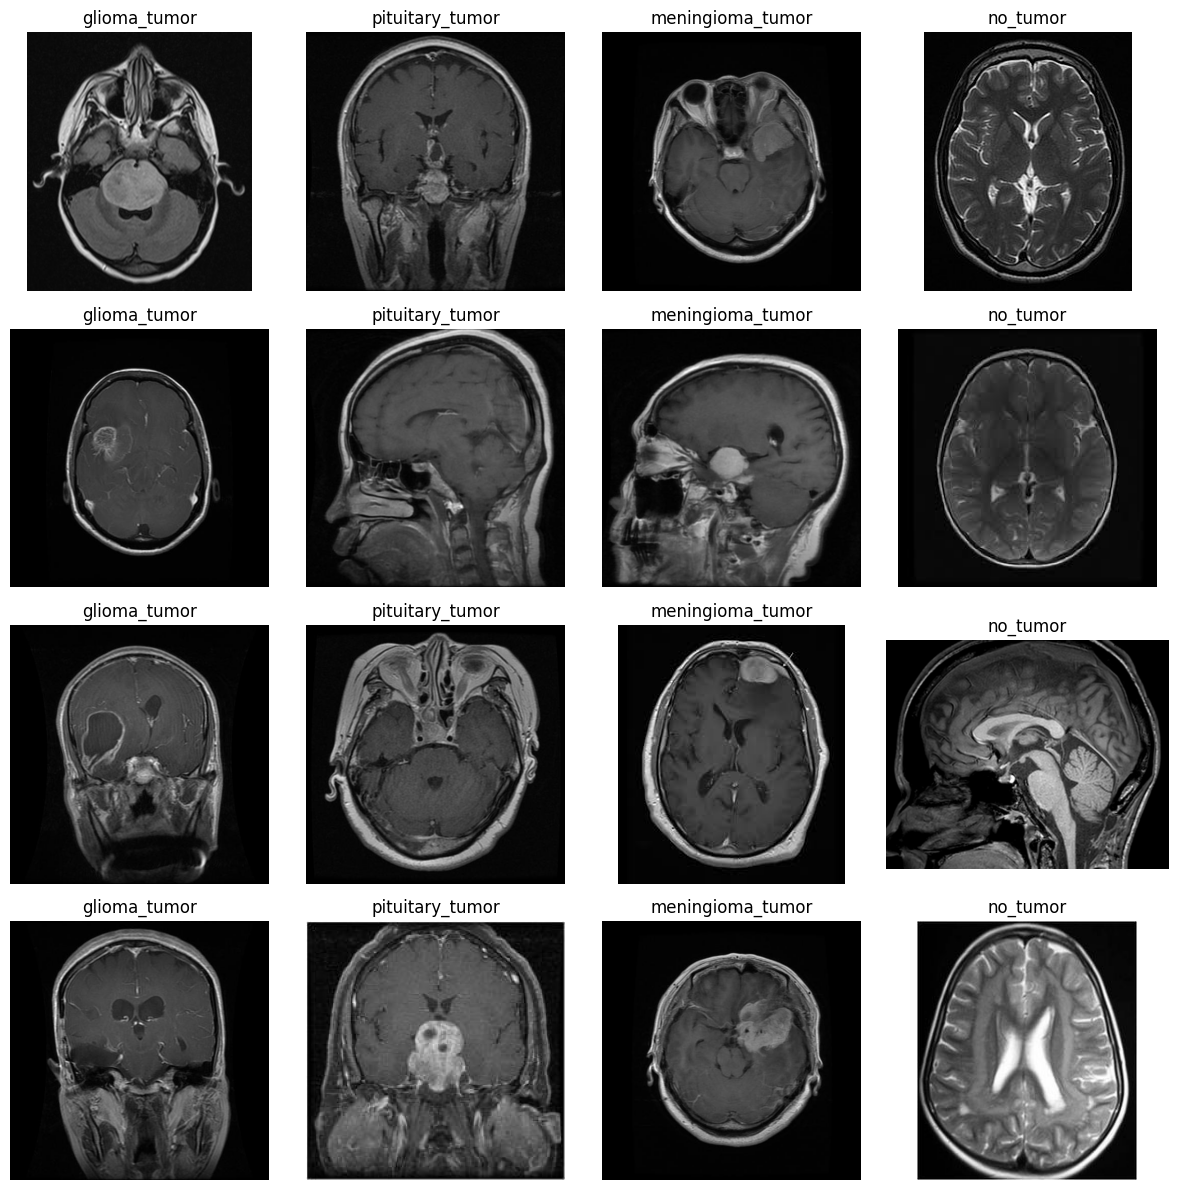

In [27]:
main_folder = r'/kaggle/working/merged_brain_tumor_dataset'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

In [28]:
cnn_merged_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_merged_generator = cnn_merged_datagen.flow_from_directory(
        output_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 2000 images belonging to 4 classes.


In [29]:
cnn_predictions = cnn_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step


In [30]:
cnn_result = cnn_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9021 - f1_score: 0.8943 - loss: 1.0085 - precision: 0.9030 - recall: 0.9017


## VGG16 Model Building

In [31]:
def preprocess_vgg16(x):
    return x/255.0

In [32]:
VGG16_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)
VGG16_train_generator = VGG16_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [33]:
VGG16_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [34]:
VGG16_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)
VGG16_test_generator = VGG16_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [35]:
VGG16_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [36]:
trained_VGG16_layers = VGG16(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
for layer in trained_VGG16_layers.layers:
    layer.trainable = False

In [38]:
VGG16_model = keras.models.Sequential([
    trained_VGG16_layers,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(VGG16_test_generator.class_indices), activation='softmax')
]) 

In [39]:
VGG16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='VGG16_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [41]:
VGG16_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),
                                   keras.metrics.Recall(name='recall'),
                                   keras.metrics.F1Score(name='f1_score')
])

In [42]:
VGG16_history = VGG16_model.fit(
        VGG16_train_generator,
        epochs = 20,
        validation_data = VGG16_test_generator,
        callbacks = callbacks
        )

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7216 - f1_score: 0.7145 - loss: 1.2577 - precision: 0.7423 - recall: 0.6934
Epoch 1: val_loss improved from inf to 0.26641, saving model to VGG16_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 331ms/step - accuracy: 0.7223 - f1_score: 0.7152 - loss: 1.2538 - precision: 0.7429 - recall: 0.6941 - val_accuracy: 0.9024 - val_f1_score: 0.8985 - val_loss: 0.2664 - val_precision: 0.9103 - val_recall: 0.8902 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9262 - f1_score: 0.9215 - loss: 0.1990 - precision: 0.9323 - recall: 0.9211
Epoch 2: val_loss improved from 0.26641 to 0.25074, saving model to VGG16_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - accuracy: 0.9263 - f1_score: 0.9216 - loss: 0.1989 - precision: 0.9324 - recall: 0.9212 - val_accuracy: 0.8993 - val_f1_score: 0.8922 - val_loss: 0.2507 - val_precision: 0.9024 - val_recall: 0.8955 - learning_rate: 0.001

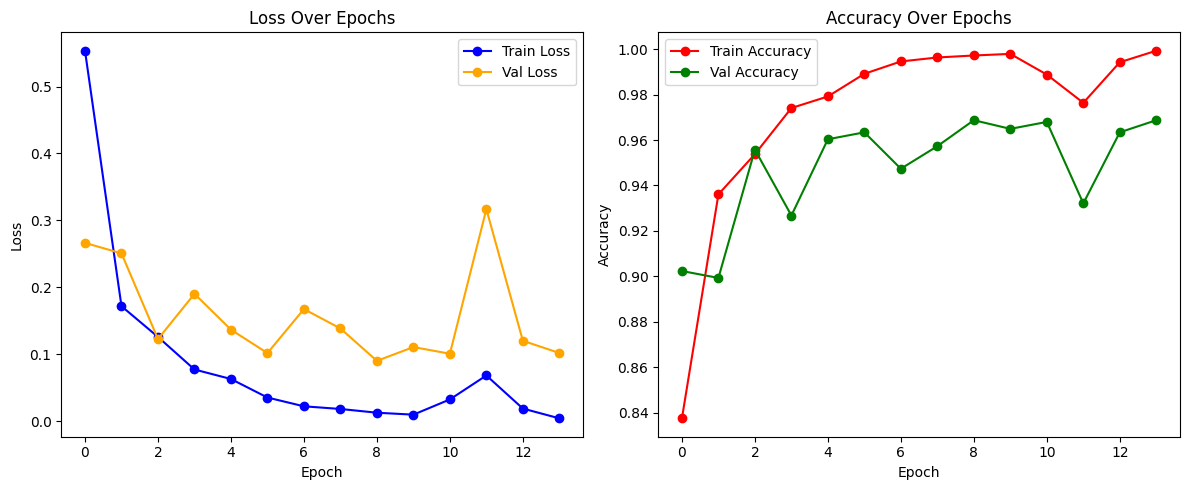

In [43]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(VGG16_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(VGG16_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG16_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(VGG16_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
vgg16_predictions = VGG16_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step


In [45]:
vgg16_result = VGG16_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.9327 - f1_score: 0.9299 - loss: 0.4107 - precision: 0.9368 - recall: 0.9312


## VGG19 Model Building

In [46]:
def preprocess_vgg19(x):
    return x/255.0

In [47]:
VGG19_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg19)
VGG19_train_generator = VGG19_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [48]:
VGG19_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [49]:
VGG19_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg19)
VGG19_test_generator = VGG19_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [50]:
VGG19_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [51]:
trained_VGG19_layers = VGG19(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [52]:
for layer in trained_VGG19_layers.layers:
    layer.trainable = False

In [53]:
VGG19_model = keras.models.Sequential([
    trained_VGG19_layers,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(VGG16_test_generator.class_indices), activation='softmax')
]) 

In [54]:
VGG19_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,448,196 (100.89 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [55]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='VGG19_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [56]:
VGG19_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.F1Score(name='f1_score')
])

In [57]:
VGG19_history = VGG19_model.fit(
        VGG19_train_generator,
        epochs = 20,
        validation_data = VGG19_test_generator,
        callbacks = callbacks
        )

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7065 - f1_score: 0.6949 - loss: 1.3490 - precision: 0.7255 - recall: 0.6798
Epoch 1: val_loss improved from inf to 0.31426, saving model to VGG19_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 290ms/step - accuracy: 0.7072 - f1_score: 0.6955 - loss: 1.3449 - precision: 0.7261 - recall: 0.6805 - val_accuracy: 0.8833 - val_f1_score: 0.8771 - val_loss: 0.3143 - val_precision: 0.8895 - val_recall: 0.8719 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9194 - f1_score: 0.9168 - loss: 0.2197 - precision: 0.9274 - recall: 0.9124
Epoch 2: val_loss improved from 0.31426 to 0.23124, saving model to VGG19_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.9194 - f1_score: 0.9168 - loss: 0.2197 - precision: 0.9274 - recall: 0.9124 - val_accuracy: 0.9031 - val_f1_score: 0.8998 - val_loss: 0.2312 - val_precision: 0.9189 - val_recall: 0.8986 - learning_rate: 0.001

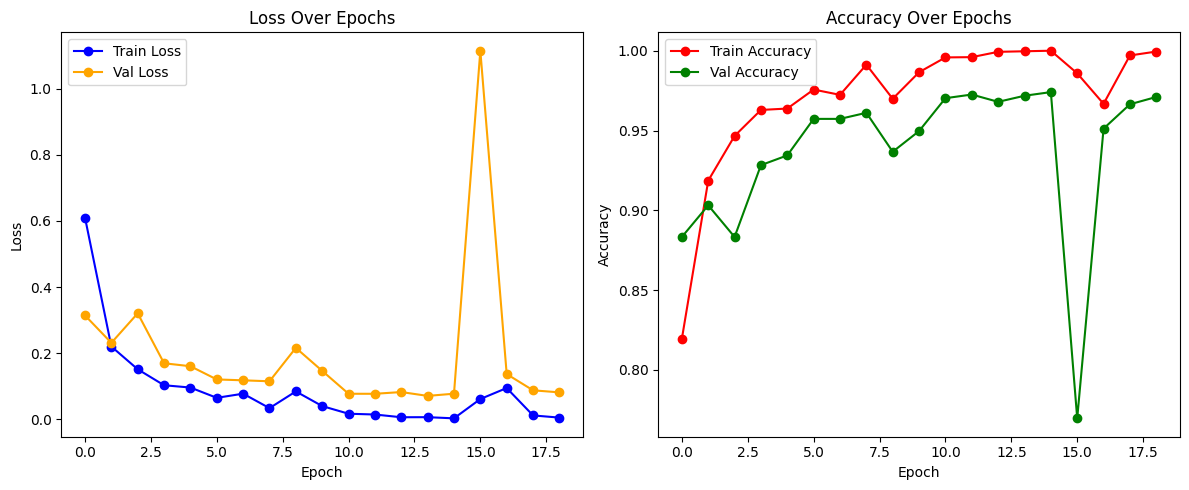

In [58]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(VGG19_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(VGG19_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG19_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(VGG19_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
vgg19_predictions = VGG19_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step


In [60]:
vgg19_result = VGG19_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.9401 - f1_score: 0.9392 - loss: 0.4358 - precision: 0.9403 - recall: 0.9401


## ResNet Model Building

In [61]:
def preprocess_resnet(x):
    return x/255.0

In [62]:
ResNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet)
ResNet_train_generator = ResNet_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [63]:
ResNet_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [64]:
ResNet_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet)
ResNet_test_generator = ResNet_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [65]:
ResNet_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [66]:
trained_ResNet_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [67]:
for layer in trained_ResNet_layers.layers:
    layer.trainable = False

In [68]:
ResNet_model = keras.models.Sequential([
    trained_ResNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(ResNet_test_generator.class_indices), activation='softmax')
])

In [69]:
ResNet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [70]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='ResNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [71]:
ResNet_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.F1Score(name='f1_score')                      
])

In [72]:
ResNet_history = ResNet_model.fit(
        ResNet_train_generator,
        epochs = 20,
        validation_data = ResNet_test_generator,
        callbacks = callbacks
        )

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7793 - f1_score: 0.7707 - loss: 0.6273 - precision: 0.8044 - recall: 0.7529
Epoch 1: val_loss improved from inf to 0.27969, saving model to ResNet_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 197ms/step - accuracy: 0.7797 - f1_score: 0.7711 - loss: 0.6261 - precision: 0.8048 - recall: 0.7534 - val_accuracy: 0.8917 - val_f1_score: 0.8845 - val_loss: 0.2797 - val_precision: 0.9041 - val_recall: 0.8841 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9292 - f1_score: 0.9259 - loss: 0.1850 - precision: 0.9376 - recall: 0.9232
Epoch 2: val_loss improved from 0.27969 to 0.20709, saving model to ResNet_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.9292 - f1_score: 0.9259 - loss: 0.1850 - precision: 0.9376 - recall: 0.9232 - val_accuracy: 0.9138 - val_f1_score: 0.9082 - val_loss: 0.2071 - val_precision: 0.9213 - val_recall: 0.9108 - learning_rate: 0.00

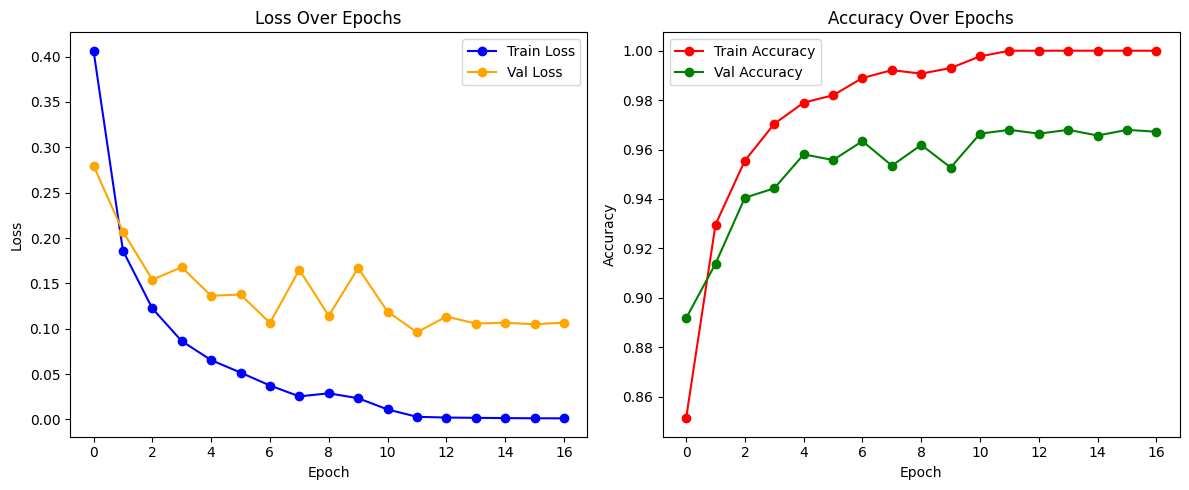

In [73]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(ResNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(ResNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(ResNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(ResNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
resnet_predictions = ResNet_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step


In [75]:
resnet_result = ResNet_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9703 - f1_score: 0.9704 - loss: 0.2199 - precision: 0.9703 - recall: 0.9692


## MobileNet Model Building

In [76]:
def preprocess_mobilenet(x):
    return x/255.0

In [77]:
MobileNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)
MobileNet_train_generator = MobileNet_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [78]:
MobileNet_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [79]:
MobileNet_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)
MobileNet_test_generator = MobileNet_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [80]:
MobileNet_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [81]:
trained_MobileNet_layers = MobileNetV2(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [82]:
for layer in trained_MobileNet_layers.layers:
    layer.trainable = False

In [83]:
MobileNet_model = keras.models.Sequential([
    trained_MobileNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(MobileNet_test_generator.class_indices), activation='softmax')
]) 

In [84]:
MobileNet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [85]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='MobileNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [86]:
MobileNet_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.F1Score(name='f1_score')
])

In [87]:
MobileNet_history = MobileNet_model.fit(
        MobileNet_train_generator,
        epochs = 20,
        validation_data = MobileNet_test_generator,
        callbacks = callbacks
        )

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7852 - f1_score: 0.7782 - loss: 0.5660 - precision: 0.8243 - recall: 0.7423
Epoch 1: val_loss improved from inf to 0.29589, saving model to MobileNet_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.7856 - f1_score: 0.7786 - loss: 0.5651 - precision: 0.8246 - recall: 0.7428 - val_accuracy: 0.8841 - val_f1_score: 0.8777 - val_loss: 0.2959 - val_precision: 0.8921 - val_recall: 0.8764 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9072 - f1_score: 0.9029 - loss: 0.2296 - precision: 0.9104 - recall: 0.9009
Epoch 2: val_loss improved from 0.29589 to 0.23674, saving model to MobileNet_best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.9072 - f1_score: 0.9029 - loss: 0.2296 - precision: 0.9104 - recall: 0.9010 - val_accuracy: 0.9092 - val_f1_score: 0.9023 - val_loss: 0.2367 - val_precision: 0.9146 - val_recall: 0.8986 - learning_rate

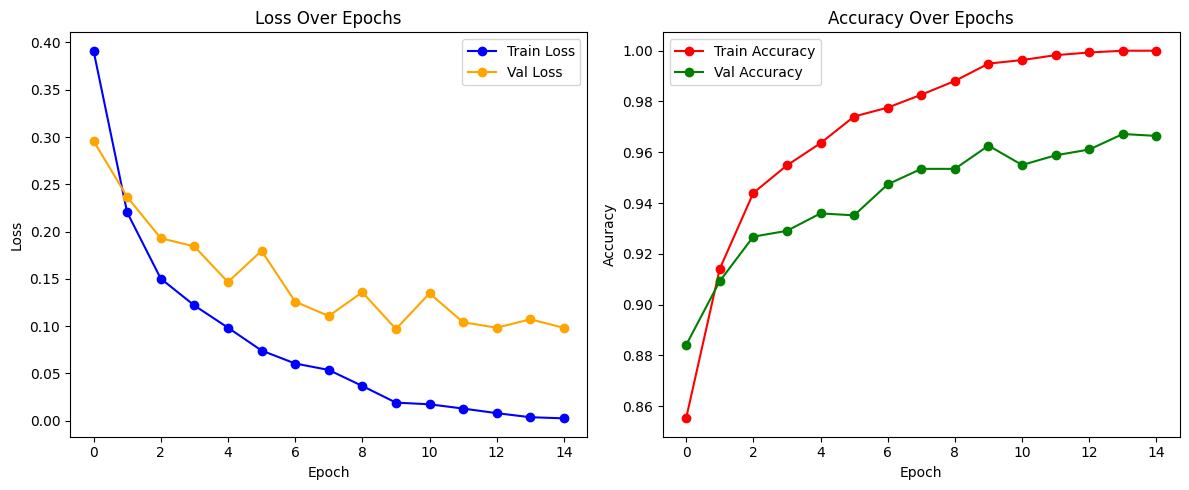

In [88]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(MobileNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(MobileNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(MobileNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(MobileNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [89]:
mobilenet_predictions = MobileNet_model.predict(cnn_merged_generator)
mobilenet_result = MobileNet_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9670 - f1_score: 0.9666 - loss: 0.2468 - precision: 0.9692 - recall: 0.9651


## Compare Between Models

In [90]:
history = {
    "CNN": {"accuracy": cnn_history.history['accuracy'],"val_accuracy": cnn_history.history['val_accuracy'] ,"loss": cnn_history.history['loss'],"val_loss": cnn_history.history['val_loss']},
    "MobileNetV2": {"accuracy": MobileNet_history.history['accuracy'],"val_accuracy": MobileNet_history.history['val_accuracy'], "loss": MobileNet_history.history['loss'],"val_loss": MobileNet_history.history['val_loss']},
    "VGG16": {"accuracy": VGG16_history.history['accuracy'],"val_accuracy": VGG16_history.history['val_accuracy'], "loss": VGG16_history.history['loss'],"val_loss": VGG16_history.history['val_loss']},
    "VGG19": {"accuracy": VGG19_history.history['accuracy'],"val_accuracy": VGG19_history.history['val_accuracy'], "loss": VGG19_history.history['loss'],"val_loss": VGG19_history.history['val_loss']},
    "ResNet50V2": {"accuracy": ResNet_history.history['accuracy'],"val_accuracy": ResNet_history.history['val_accuracy'], "loss": ResNet_history.history['loss'],"val_loss": ResNet_history.history['val_loss']}
}

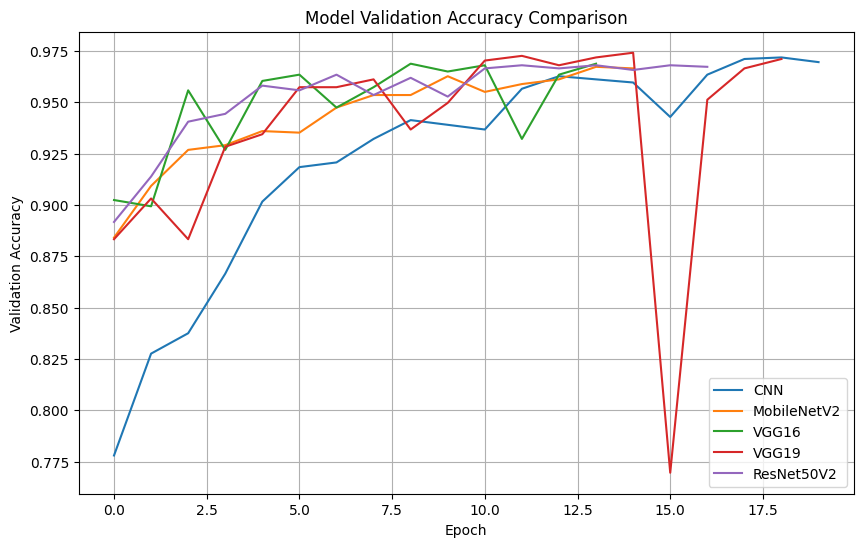

In [91]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_accuracy'], label=model)
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

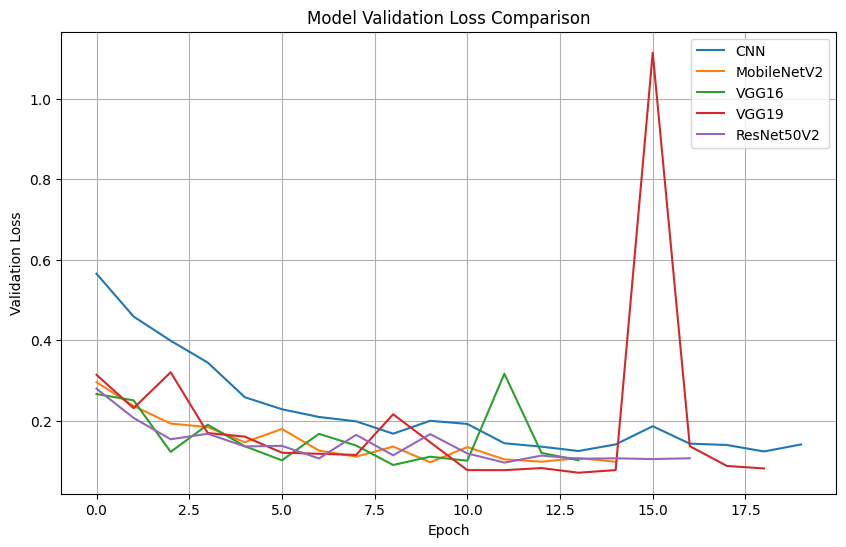

In [92]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_loss'], label=model)
plt.title('Model Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

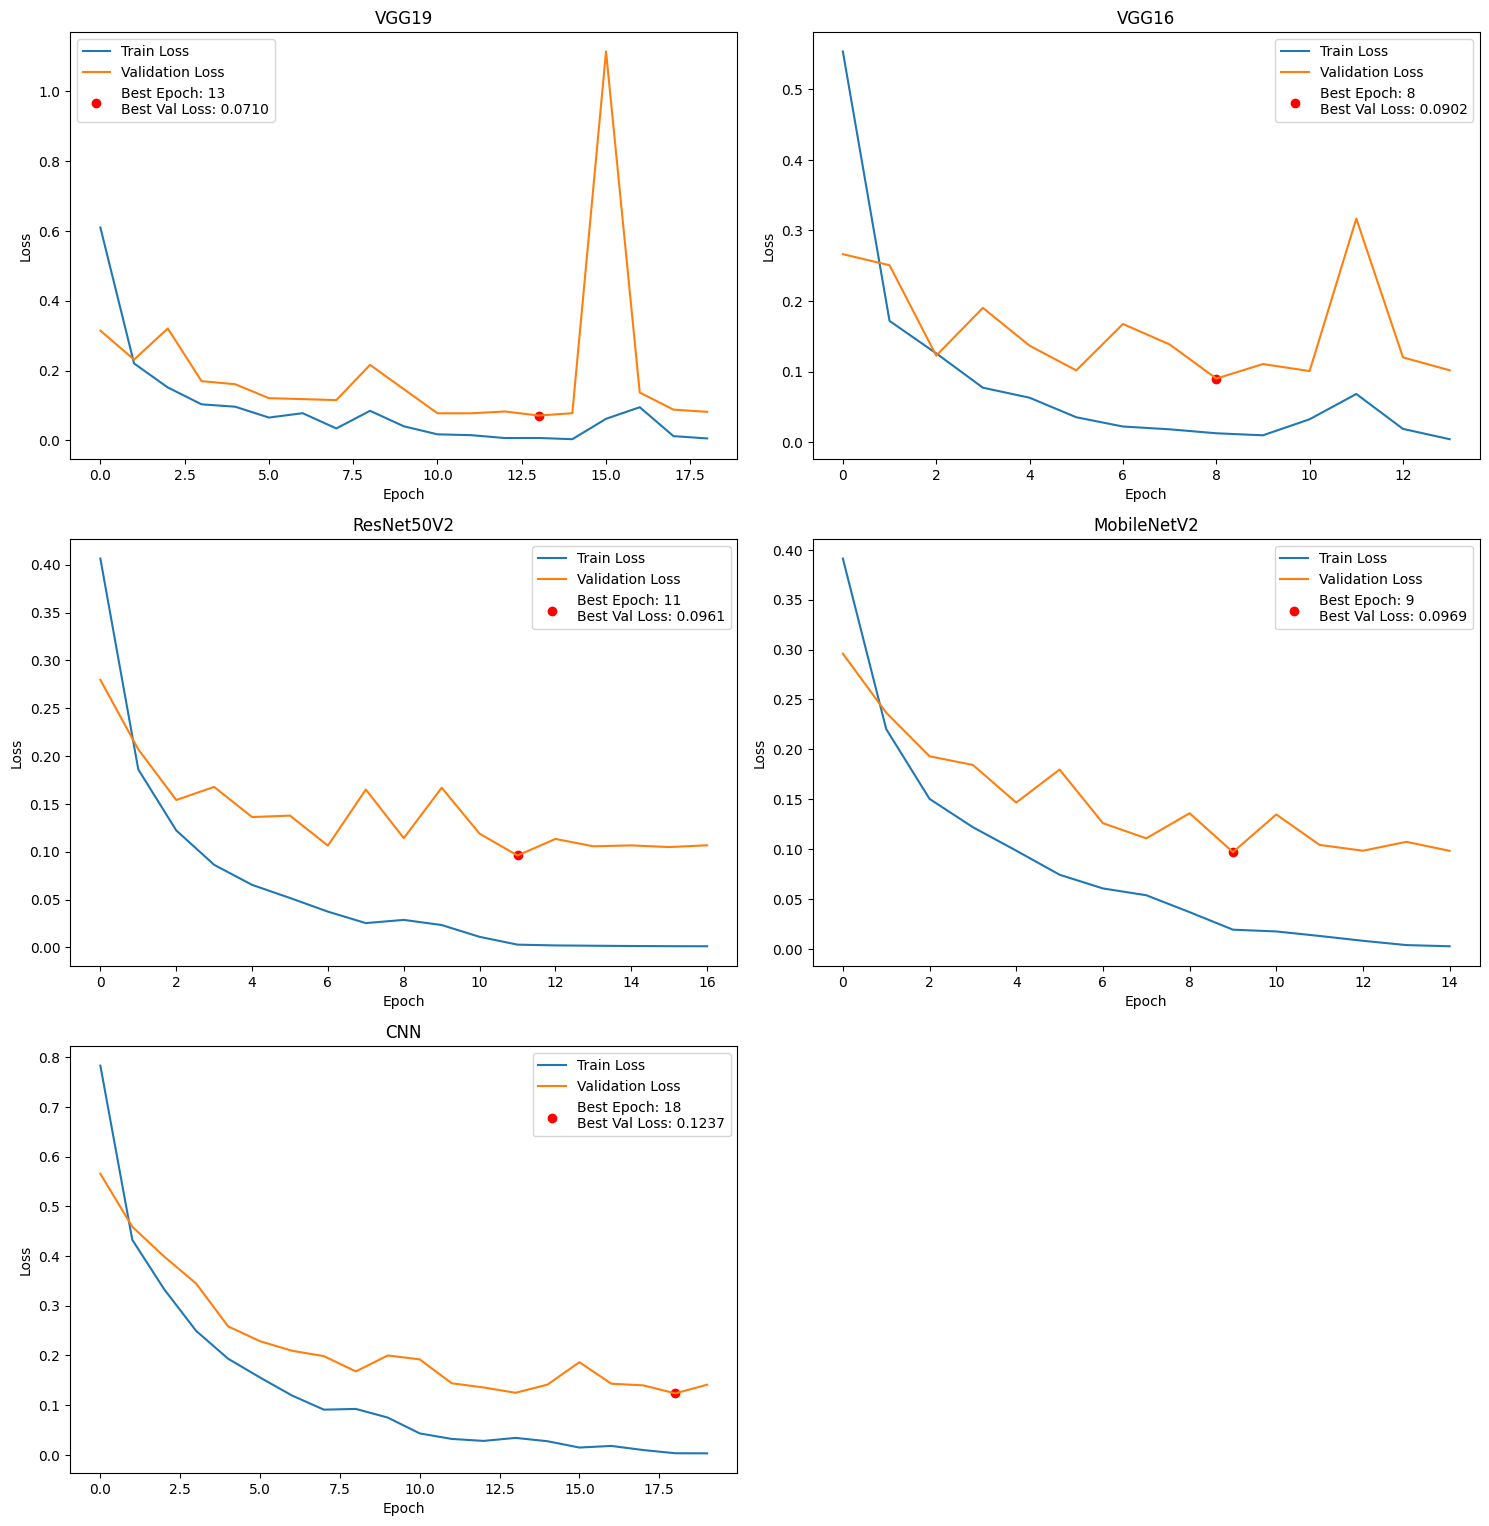

In [93]:
plt.figure(figsize=(15, 20))

# Sort models by least validation loss
sorted_models = sorted(history.items(), key=lambda x: min(x[1]['val_loss']))

# Plot each model based on sorted order of least val_loss
for i, (model_name, model_history) in enumerate(sorted_models, 1):
    plt.subplot(4, 2, i) 
    plt.plot(model_history['loss'], label='Train Loss')
    plt.plot(model_history['val_loss'], label='Validation Loss')

    # Find the best epoch based on least val_loss
    min_val_loss_epoch = model_history['val_loss'].index(min(model_history['val_loss']))
    min_val_loss = min(model_history['val_loss'])

    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Best Epoch: {min_val_loss_epoch}\nBest Val Loss: {min_val_loss:.4f}')

    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

In [94]:
best_CNN = load_model('/kaggle/working/CNN_best_model.keras')
best_MobileNetV2 = load_model('/kaggle/working/MobileNet_best_model.keras')
best_VGG16 = load_model('/kaggle/working/VGG16_best_model.keras')
best_VGG19 = load_model('/kaggle/working/VGG19_best_model.keras')
best_ResNet50 = load_model('/kaggle/working/ResNet_best_model.keras')

In [95]:
models = ['Best CNN','Best MobileNetV2','Best VGG16','Best VGG19','Best ResNest50']
best_train_accuracy= [
                        cnn_history.history['accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        MobileNet_history.history['accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
                        VGG16_history.history['accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
                        VGG19_history.history['accuracy'][np.argmax(VGG19_history.history['val_accuracy'])],
                        ResNet_history.history['accuracy'][np.argmax(ResNet_history.history['val_accuracy'])]
                     ]
best_val_accuracy= [
                        cnn_history.history['val_accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        MobileNet_history.history['val_accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
                        VGG16_history.history['val_accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
                        VGG19_history.history['val_accuracy'][np.argmax(VGG19_history.history['val_accuracy'])],
                        ResNet_history.history['val_accuracy'][np.argmax(ResNet_history.history['val_accuracy'])]
                     ]

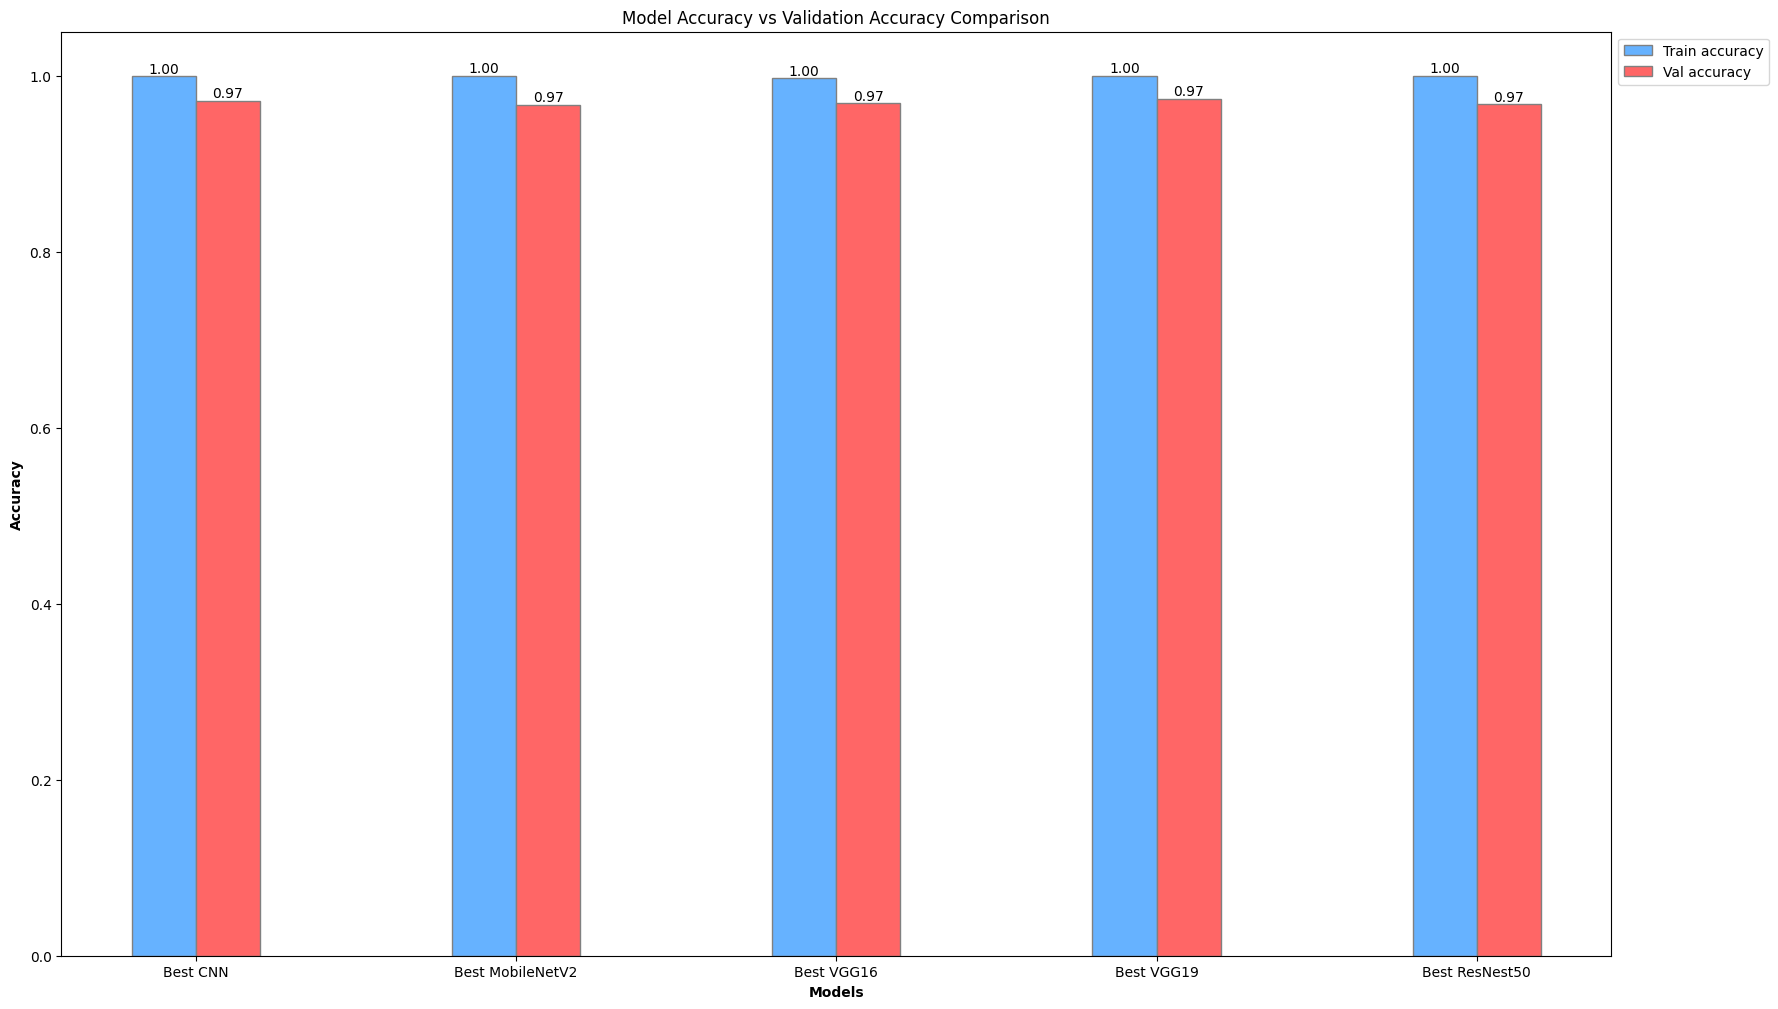

In [96]:
barWidth = 0.20

r1 = np.arange(len(best_train_accuracy))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20, 12))
bars1 = plt.bar(r1, best_train_accuracy, color='#66B2FF', width=barWidth, edgecolor='grey', label='Train accuracy')
bars2 = plt.bar(r2, best_val_accuracy, color='#FF6666', width=barWidth, edgecolor='grey', label='Val accuracy')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(best_train_accuracy))], models)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Model Accuracy vs Validation Accuracy Comparison')
plt.show()

Accuracy values:
CNN: 0.8905
VGG16: 0.9355
VGG19: 0.9340
ResNet: 0.9700
MobileNet: 0.9600


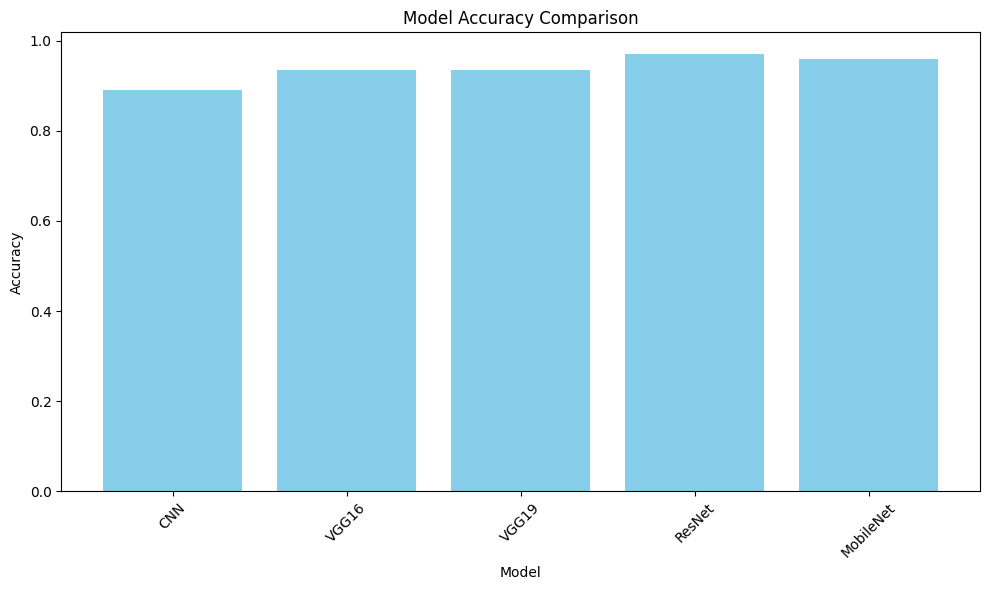

In [97]:
THE_ALL_RESULTS = {
    'CNN': cnn_result[1],
    'VGG16': vgg16_result[1], 
    'VGG19': vgg19_result[1],
    'ResNet': resnet_result[1],
    'MobileNet': mobilenet_result[1]
}

print("Accuracy values:")
for model, accuracy in THE_ALL_RESULTS.items():
    print(f"{model}: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(THE_ALL_RESULTS.keys(), THE_ALL_RESULTS.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Accuracy values:
CNN: 0.8905
VGG16: 0.9355
VGG19: 0.9340
ResNet: 0.9700
MobileNet: 0.9600


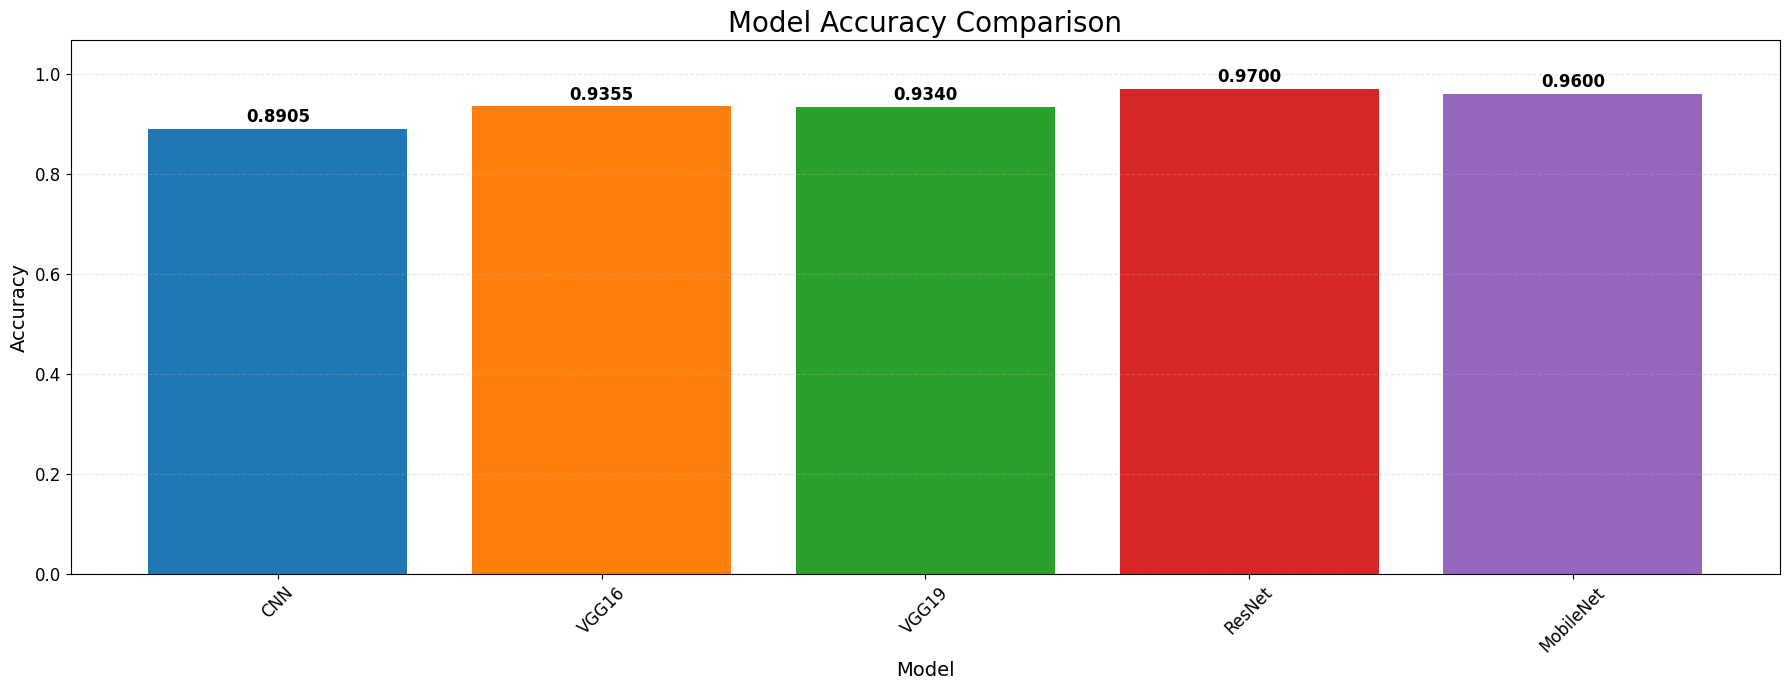

In [98]:
THE_ALL_RESULTS = {
    'CNN': cnn_result[1],
    'VGG16': vgg16_result[1], 
    'VGG19': vgg19_result[1],
    'ResNet': resnet_result[1],
    'MobileNet': mobilenet_result[1]
}

print("Accuracy values:")
for model, accuracy in THE_ALL_RESULTS.items():
    print(f"{model}: {accuracy:.4f}")

plt.figure(figsize=(18, 7))
bars = plt.bar(THE_ALL_RESULTS.keys(), THE_ALL_RESULTS.values(), 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Add value labels on top of each bar
for bar, (model, accuracy) in zip(bars, THE_ALL_RESULTS.items()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{accuracy:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Model Accuracy Comparison', fontsize=20)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis limits to better show differences
plt.ylim(0, max(THE_ALL_RESULTS.values()) * 1.1)

plt.tight_layout()
plt.show()




Models ranked by accuracy:
1. ResNet: 0.9700
2. MobileNet: 0.9600
3. VGG16: 0.9355
4. VGG19: 0.9340
5. CNN: 0.8905


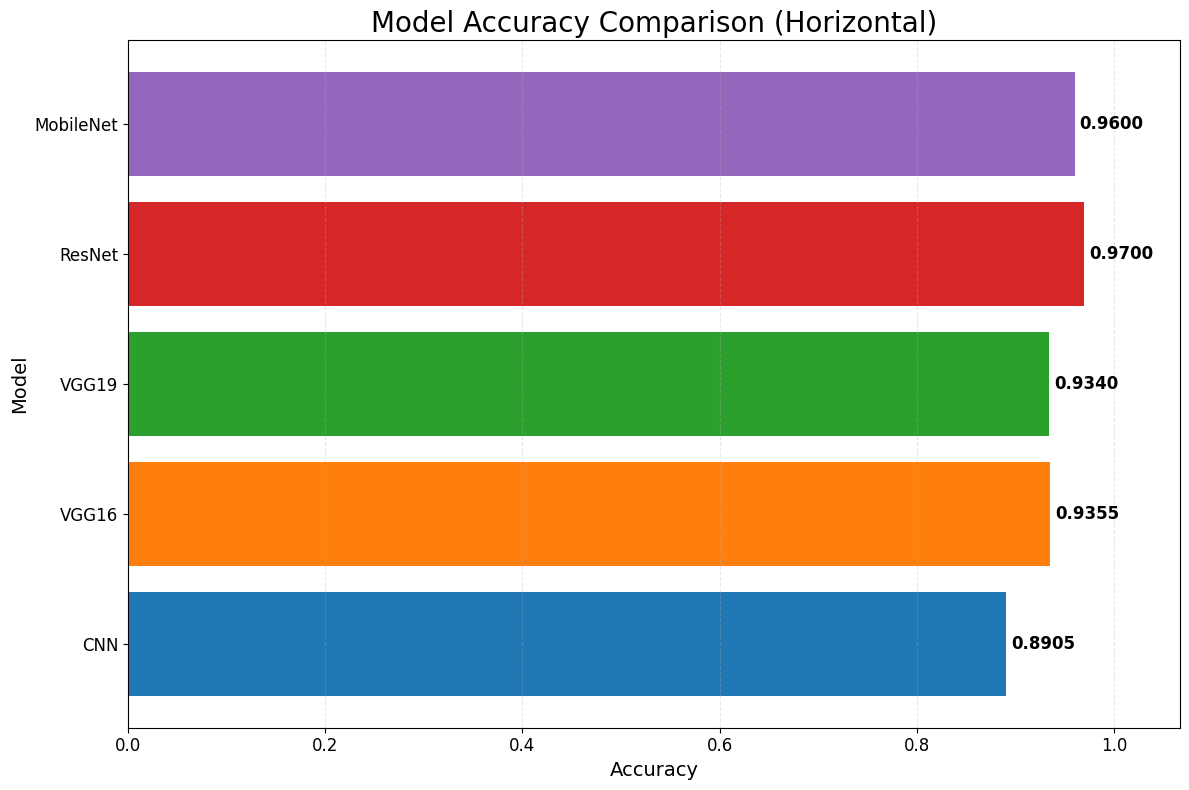

In [99]:
print("\nModels ranked by accuracy:")
sorted_results = sorted(THE_ALL_RESULTS.items(), key=lambda x: x[1], reverse=True)
for i, (model, accuracy) in enumerate(sorted_results, 1):
    print(f"{i}. {model}: {accuracy:.4f}")

plt.figure(figsize=(12, 8))
models = list(THE_ALL_RESULTS.keys())
accuracies = list(THE_ALL_RESULTS.values())

bars = plt.barh(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Add value labels at the end of each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.4f}', ha='left', va='center', fontsize=12, fontweight='bold')

plt.title('Model Accuracy Comparison (Horizontal)', fontsize=20)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Set x-axis limits to better show differences
plt.xlim(0, max(THE_ALL_RESULTS.values()) * 1.1)

plt.tight_layout()
plt.show()